In [2]:
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
from tensorflow.keras.utils import load_img, img_to_array

In [3]:
MODEL_TARGET = os.environ.get('MODEL_TARGET')
GCP_PROJECT = os.environ.get('GCP_PROJECT')
GCP_REGION = os.environ.get('GCP_REGION')

BUCKET_NAME = os.environ.get('BUCKET_NAME')
BQ_REGION = os.environ.get('BQ_REGION')
BQ_DATASET = os.environ.get('BQ_DATASET')
PLATE_NUMBER = os.environ.get('PLATE_NUMBER')

LOCAL_DATA_PATH = os.path.join(os.path.expanduser('~'), ".morpho_minds_data")

In [4]:
data_df = pd.read_csv(os.path.join(LOCAL_DATA_PATH, PLATE_NUMBER, 'processed', f'{PLATE_NUMBER}_small.csv'))
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PhGolgi      2304 non-null   object 
 1   Hoechst      2304 non-null   object 
 2   ERSyto       2304 non-null   object 
 3   Mito         2304 non-null   object 
 4   ERSytoBleed  2304 non-null   object 
 5   CellCount    2304 non-null   int64  
 6   Well         2304 non-null   object 
 7   PhotoNumber  2304 non-null   int64  
 8   Role         2304 non-null   object 
 9   MMoles       2304 non-null   float64
 10  Plate        2304 non-null   int64  
 11  MeanArea     2304 non-null   float64
dtypes: float64(2), int64(3), object(7)
memory usage: 216.1+ KB


In [5]:
paths_df = data_df['PhGolgi'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(PLATE_NUMBER, 'raw', 'pictures', f'{PLATE_NUMBER}-Ph_golgi', x.split('/')[-1])))

In [6]:
channel_image_files = {'channel' : []}
channel_images = {'channel' : []}

for path in paths_df:

    channel_image_files['channel'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images['channel'].append(img_array_expanded)

images_batch = np.vstack(channel_images['channel'])

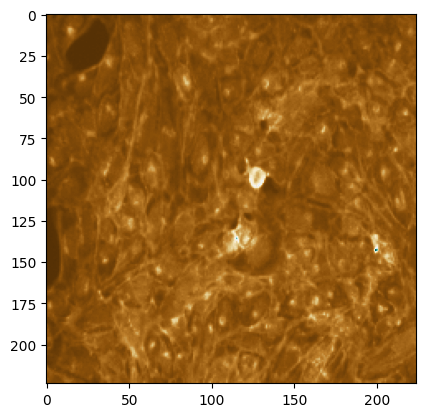

In [7]:
#images_batch/=65535
plt.imshow(images_batch[0, :, :, 0], cmap='BrBG')

In [41]:
X_train, X_test, y_train, y_test = train_test_split(images_batch, data_df['MeanArea'], test_size=0.2, random_state=42)

In [8]:
base_model_score = np.sum((data_df['MeanArea'] - data_df['MeanArea'].mean())**2)/data_df.shape[0]
base_model_score

357186.6667341978

In [65]:
def initialize_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, kernel_size=(4,4), activation = 'relu', input_shape = (224,224,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(10, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss='mse',
                  optimizer='adam',
                  metrics='mae')

    return model

In [66]:
model = initialize_model()
es = EarlyStopping(patience = 15, restore_best_weights = True)

history = model.fit(X_train,
                    y_train,
                    validation_split = 0.3,
                    batch_size = 32,
                    epochs = 100,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/100
41/41 [==============================] - 12s 289ms/step - loss: 1449935.6250 - mae: 902.5494 - val_loss: 814595.6250 - val_mae: 732.5516
Epoch 2/100
41/41 [==============================] - 13s 317ms/step - loss: 832067.9375 - mae: 698.9511 - val_loss: 951176.8125 - val_mae: 734.5804
Epoch 3/100
41/41 [==============================] - 12s 286ms/step - loss: 787445.3750 - mae: 678.1820 - val_loss: 904771.6250 - val_mae: 758.6349
Epoch 4/100
41/41 [==============================] - 11s 258ms/step - loss: 761190.8125 - mae: 668.8503 - val_loss: 805852.3750 - val_mae: 694.4277
Epoch 5/100
41/41 [==============================] - 12s 285ms/step - loss: 656738.6875 - mae: 620.2170 - val_loss: 883223.1875 - val_mae: 711.4506
Epoch 6/100
41/41 [==============================] - 12s 284ms/step - loss: 623710.9375 - mae: 600.0674 - val_loss: 833923.1875 - val_mae: 707.8376
Epoch 7/100
41/41 [==============================] - 11s 277ms/step - loss: 602347.9375 - mae: 593.8371 - val_l

In [67]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 1s 55ms/step - loss: 530695.0000 - mae: 551.9249


[530695.0, 551.9249267578125]

1640    1943.209677
508     3089.558824
1422    2532.900901
44      1169.848485
1398    2023.597015
           ...     
1825    2632.601852
1674    2036.045455
1813    2107.811475
1776    2073.785185
2227    2700.059406
Name: MeanArea, Length: 461, dtype: float64

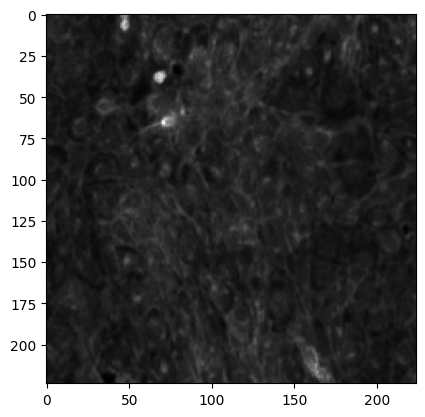

In [68]:
plt.imshow(X_test[0], cmap='gray')
y_test

In [69]:
model.predict(X_test[0].reshape(1, 224, 224, 1))

1/1 [==============================] - 0s 44ms/step


array([[2028.87]], dtype=float32)

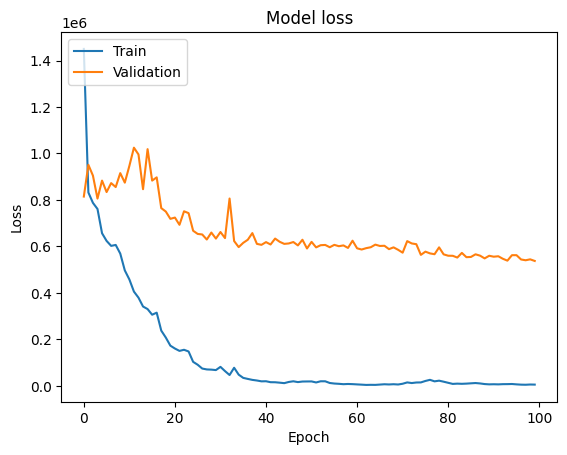

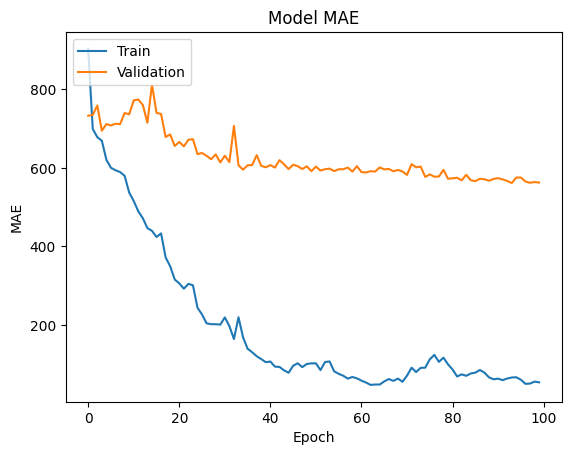

In [70]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation metrics (e.g., MAE)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot learning curves for the model trained with data from both channels
plot_learning_curves(history)

In [71]:
paths_df = data_df['ERSytoBleed'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(PLATE_NUMBER, 'raw', 'pictures', f'{PLATE_NUMBER}-ERSytoBleed', x.split('/')[-1])))
channel_image_files = {'channel' : []}
channel_images = {'channel' : []}

for path in paths_df:

    channel_image_files['channel'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images['channel'].append(img_array_expanded)

images_batch = np.vstack(channel_images['channel'])

X_train, X_test, y_train, y_test = train_test_split(images_batch, data_df['MeanArea'], test_size=0.2, random_state=42)

def initialize_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, kernel_size=(4,4), activation = 'relu', input_shape = (224,224,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(128, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(20, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss='mse',
                  optimizer='adam',
                  metrics='mae')

    return model

model = initialize_model()
es = EarlyStopping(patience = 15, restore_best_weights = True)

history = model.fit(X_train,
                    y_train,
                    validation_split = 0.3,
                    batch_size = 32,
                    epochs = 100,
                    callbacks = [es],
                    verbose = 1)


Epoch 1/100
41/41 [==============================] - 12s 275ms/step - loss: 1215874.3750 - mae: 847.6929 - val_loss: 800389.1250 - val_mae: 734.4622
Epoch 2/100
41/41 [==============================] - 11s 273ms/step - loss: 839878.1250 - mae: 707.1824 - val_loss: 854968.8125 - val_mae: 775.5400
Epoch 3/100
41/41 [==============================] - 11s 272ms/step - loss: 815567.0000 - mae: 705.9307 - val_loss: 772136.2500 - val_mae: 697.1923
Epoch 4/100
41/41 [==============================] - 11s 269ms/step - loss: 798660.3750 - mae: 689.6260 - val_loss: 1024411.0625 - val_mae: 747.2167
Epoch 5/100
41/41 [==============================] - 12s 305ms/step - loss: 784477.6875 - mae: 694.4791 - val_loss: 747427.9375 - val_mae: 690.3624
Epoch 6/100
41/41 [==============================] - 13s 312ms/step - loss: 683566.4375 - mae: 643.6883 - val_loss: 738965.8750 - val_mae: 701.6400
Epoch 7/100
41/41 [==============================] - 11s 276ms/step - loss: 651506.9375 - mae: 630.1454 - val_

In [72]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 1s 57ms/step - loss: 434611.7812 - mae: 496.9431


[434611.78125, 496.9431457519531]

1640    1943.209677
508     3089.558824
1422    2532.900901
44      1169.848485
1398    2023.597015
           ...     
1825    2632.601852
1674    2036.045455
1813    2107.811475
1776    2073.785185
2227    2700.059406
Name: MeanArea, Length: 461, dtype: float64

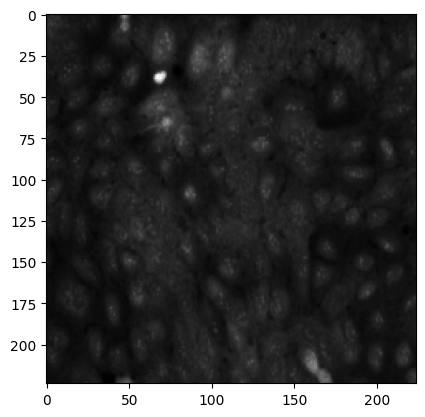

In [73]:
plt.imshow(X_test[0], cmap='gray')
y_test

In [74]:
model.predict(X_test[0].reshape(1, 224, 224, 1))

1/1 [==============================] - 0s 47ms/step


array([[2198.6187]], dtype=float32)

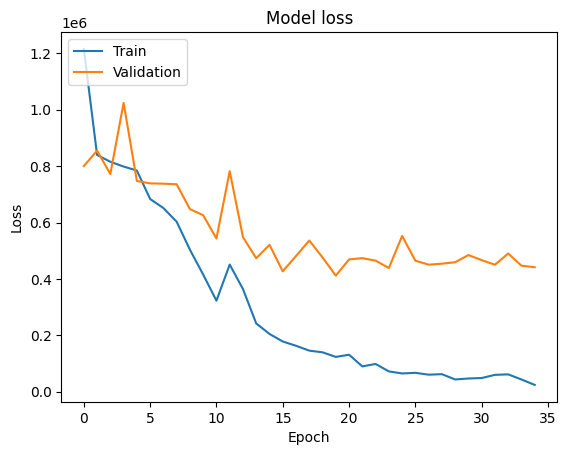

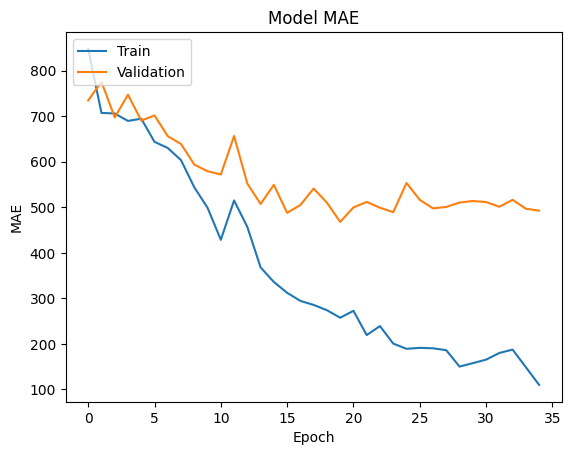

In [75]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation metrics (e.g., MAE)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot learning curves for the model trained with data from both channels
plot_learning_curves(history)

# Model with 2 Channels and 1 plate trained

In [9]:
# Load paths for images from the PhGolgi channel
paths_df_phgolgi = data_df['PhGolgi'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(PLATE_NUMBER, 'raw', 'pictures', f'{PLATE_NUMBER}-Ph_golgi', x.split('/')[-1])))
paths_df_Hoechst = data_df['Hoechst'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(PLATE_NUMBER, 'raw', 'pictures', f'{PLATE_NUMBER}-Hoechst', x.split('/')[-1])))

# Initialize dictionaries to hold file paths and images for both channels
channel_image_files_both = {'ERSytoBleed': [], 'Ph_golgi': [], 'Hoechst':[]}
channel_images_both = {'ERSytoBleed': [], 'Ph_golgi': [], 'Hoechst':[]}

# Loop through paths and load images for the ERSytoBleed channel
for path in paths_df:
    channel_image_files_both['ERSytoBleed'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images_both['ERSytoBleed'].append(img_array_expanded)

# Loop through paths and load images for the PhGolgi channel
for path in paths_df_phgolgi:
    channel_image_files_both['Ph_golgi'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images_both['Ph_golgi'].append(img_array_expanded)

# for path in paths_df_Hoechst:
#     channel_image_files_both['Hoechst'].append(path)

#     img = load_img(path, target_size=(224, 224), color_mode='grayscale')
#     img_array = img_to_array(img)
#     img_array_expanded = np.expand_dims(img_array, axis=0)

#     channel_images_both['Hoechst'].append(img_array_expanded)

# Stack images to create a batch for each channel
images_batch_ersyto = np.vstack(channel_images_both['ERSytoBleed'])
images_batch_phgolgi = np.vstack(channel_images_both['Ph_golgi'])
# images_batch_hoechst = np.vstack(channel_images_both['Hoechst'])

# Combine images from both channels along the channel axis
images_batch_both = np.concatenate((images_batch_ersyto, images_batch_phgolgi), axis=-1)
images_batch_both.shape

X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(images_batch_both, data_df['MeanArea'], test_size=0.2, random_state=42)
X_train_both.shape, X_test_both.shape, y_train_both.shape, y_test_both.shape

((1843, 224, 224, 2), (461, 224, 224, 2), (1843,), (461,))

In [11]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def initialize_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, kernel_size=(4,4), activation = 'relu', input_shape = (224,224,2)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
    #model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(128, kernel_size=(2,2), activation = 'relu'))
    #model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(20, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    initial_learning_rate = 0.01
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics='mae')

    return model

model = initialize_model()
es = EarlyStopping(patience = 15, restore_best_weights = True)

history = model.fit(X_train_both,
                    y_train_both,
                    validation_split = 0.3,
                    batch_size = 32,
                    epochs = 500,
                    callbacks = [es],
                    verbose = 1)


Epoch 1/500
41/41 [==============================] - 20s 476ms/step - loss: 2430086656.0000 - mae: 10459.1221 - val_loss: 996171.2500 - val_mae: 745.0629
Epoch 2/500
41/41 [==============================] - 19s 454ms/step - loss: 28552674.0000 - mae: 2955.0820 - val_loss: 806162.5000 - val_mae: 692.7647
Epoch 3/500
41/41 [==============================] - 18s 448ms/step - loss: 497501.6562 - mae: 565.9771 - val_loss: 350650.4062 - val_mae: 488.5956
Epoch 4/500
41/41 [==============================] - 18s 445ms/step - loss: 356514.4688 - mae: 486.0217 - val_loss: 353844.0625 - val_mae: 485.2662
Epoch 5/500
41/41 [==============================] - 19s 458ms/step - loss: 356310.0312 - mae: 486.0458 - val_loss: 353044.0938 - val_mae: 483.4790
Epoch 6/500
41/41 [==============================] - 18s 444ms/step - loss: 352392.9375 - mae: 483.5351 - val_loss: 374241.1562 - val_mae: 477.2980
Epoch 7/500
41/41 [==============================] - 18s 445ms/step - loss: 345776.5000 - mae: 475.0863

In [13]:
model.evaluate(X_test_both, y_test_both)
print(base_model_score)

15/15 [==============================] - 2s 106ms/step - loss: 334029.5938 - mae: 468.7737
357186.6667341978


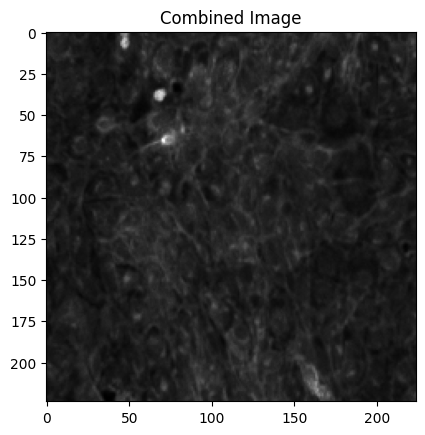

1640    1943.209677
508     3089.558824
1422    2532.900901
44      1169.848485
1398    2023.597015
           ...     
1825    2632.601852
1674    2036.045455
1813    2107.811475
1776    2073.785185
2227    2700.059406
Name: MeanArea, Length: 461, dtype: float64

In [15]:
combined_image = (X_test_both[0][:, :, 0] + X_test_both[0][:, :, 1]) / 2.0

plt.imshow(combined_image, cmap='gray')
plt.title('Combined Image')
plt.show()
y_test_both

In [18]:
model.predict(X_test_both[0].reshape(1, 224, 224, 2))

1/1 [==============================] - 0s 83ms/step


array([[2540.3782]], dtype=float32)

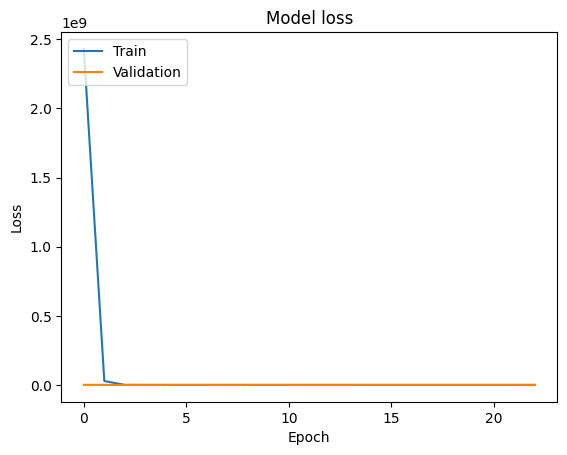

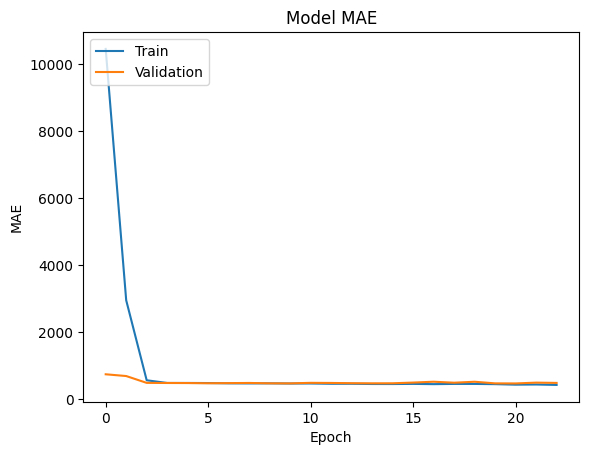

In [19]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation metrics (e.g., MAE)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot learning curves for the model trained with data from both channels
plot_learning_curves(history)

In [6]:
plates = ['24585','24639'] #'24277'

all_data_dfs = []
paths_df_phgolgi = []
#paths_df_Hoechst = []
paths_df_ERSytoBleed = []
for platenr in plates:
    data_df = pd.read_csv(os.path.join(LOCAL_DATA_PATH, platenr, 'processed', f'{platenr}_small.csv'))
    data_df['Plate'] = platenr
    all_data_dfs.append(data_df)
    paths_df_phgolgi.extend(
        data_df['PhGolgi'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(platenr, 'raw', 'pictures', f'{platenr}-Ph_golgi', x.split('/')[-1]))).tolist()
        )
    #paths_df_Hoechst.extend(
    #data_df['Hoechst'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(platenr, 'raw', 'pictures', f'{platenr}-Hoechst', x.split('/')[-1]))).tolist()
    #)
    paths_df_ERSytoBleed.extend(
    data_df['ERSytoBleed'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(platenr, 'raw', 'pictures', f'{platenr}-ERSytoBleed', x.split('/')[-1]))).tolist()
    )
concatenated_df = pd.concat(all_data_dfs, ignore_index=True)

In [14]:
# # Initialize dictionaries to hold file paths and images for tripel channels
# channel_image_files_tripel = {'ERSytoBleed': [], 'Ph_golgi': [], 'Hoechst':[]}
# channel_images_trip = {'ERSytoBleed': [], 'Ph_golgi': [], 'Hoechst':[]}

# # Loop through paths and load images for the ERSytoBleed channel
# for path in paths_df_ERSytoBleed:
#     channel_image_files_tripel['ERSytoBleed'].append(path)

#     img = load_img(path, target_size=(224, 224), color_mode='grayscale')
#     img_array = img_to_array(img)
#     img_array_expanded = np.expand_dims(img_array, axis=0)

#     channel_images_trip['ERSytoBleed'].append(img_array_expanded)

# # Loop through paths and load images for the PhGolgi channel
# for path in paths_df_phgolgi:
#     channel_image_files_tripel['Ph_golgi'].append(path)

#     img = load_img(path, target_size=(224, 224), color_mode='grayscale')
#     img_array = img_to_array(img)
#     img_array_expanded = np.expand_dims(img_array, axis=0)

#     channel_images_trip['Ph_golgi'].append(img_array_expanded)

# for path in paths_df_Hoechst:
#     channel_image_files_tripel['Hoechst'].append(path)

#     img = load_img(path, target_size=(224, 224), color_mode='grayscale')
#     img_array = img_to_array(img)
#     img_array_expanded = np.expand_dims(img_array, axis=0)

#     channel_images_trip['Hoechst'].append(img_array_expanded)

# # Stack images to create a batch for each channel
# images_batch_ersyto = np.vstack(channel_images_trip['ERSytoBleed'])
# images_batch_phgolgi = np.vstack(channel_images_trip['Ph_golgi'])
# images_batch_hoechst = np.vstack(channel_images_trip['Hoechst'])

# # Combine images from tripel channels along the channel axis
# images_batch_tripel = np.concatenate((images_batch_ersyto, images_batch_phgolgi, images_batch_hoechst), axis=-1)
# images_batch_tripel.shape


(4601, 224, 224, 3)

In [7]:
# Initialize dictionaries to hold file paths and images for multip channels
channel_image_files_multip = {'ERSytoBleed': [], 'Ph_golgi': []}
channel_images_mp = {'ERSytoBleed': [], 'Ph_golgi': []}

# Loop through paths and load images for the ERSytoBleed channel
for path in paths_df_ERSytoBleed:
    channel_image_files_multip['ERSytoBleed'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images_mp['ERSytoBleed'].append(img_array_expanded)

# Loop through paths and load images for the PhGolgi channel
for path in paths_df_phgolgi:
    channel_image_files_multip['Ph_golgi'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images_mp['Ph_golgi'].append(img_array_expanded)

# for path in paths_df_Hoechst:
#     channel_image_files_multip['Hoechst'].append(path)

#     img = load_img(path, target_size=(224, 224), color_mode='grayscale')
#     img_array = img_to_array(img)
#     img_array_expanded = np.expand_dims(img_array, axis=0)

#     channel_images_mp['Hoechst'].append(img_array_expanded)

# Stack images to create a batch for each channel
images_batch_ersyto = np.vstack(channel_images_mp['ERSytoBleed'])
images_batch_phgolgi = np.vstack(channel_images_mp['Ph_golgi'])
#images_batch_hoechst = np.vstack(channel_images_mp['Hoechst'])

# Combine images from multip channels along the channel axis
images_batch_multip = np.concatenate((images_batch_ersyto, images_batch_phgolgi), axis=-1)
images_batch_multip.shape


(4606, 224, 224, 2)

In [ ]:
# Initialize dictionaries to hold file paths and images for multip channels
channel_image_files_multip = {'ERSytoBleed': [], 'Ph_golgi': []}
channel_images_mp = {'ERSytoBleed': [], 'Ph_golgi': []}

# Loop through paths and load images for the ERSytoBleed channel
for path in paths_df_ERSytoBleed:
    channel_image_files_multip['ERSytoBleed'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images_mp['ERSytoBleed'].append(img_array_expanded)

# Loop through paths and load images for the PhGolgi channel
for path in paths_df_phgolgi:
    channel_image_files_multip['Ph_golgi'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images_mp['Ph_golgi'].append(img_array_expanded)

# for path in paths_df_Hoechst:
#     channel_image_files_multip['Hoechst'].append(path)

#     img = load_img(path, target_size=(224, 224), color_mode='grayscale')
#     img_array = img_to_array(img)
#     img_array_expanded = np.expand_dims(img_array, axis=0)

#     channel_images_mp['Hoechst'].append(img_array_expanded)

# Stack images to create a batch for each channel
images_batch_ersyto = np.vstack(channel_images_mp['ERSytoBleed'])
images_batch_phgolgi = np.vstack(channel_images_mp['Ph_golgi'])
#images_batch_hoechst = np.vstack(channel_images_mp['Hoechst'])

# Combine images from multip channels along the channel axis
images_batch_multip = np.concatenate((images_batch_ersyto, images_batch_phgolgi), axis=-1)
images_batch_multip.shape


In [8]:
images_batch_multip = images_batch_multip/65535

In [9]:
X_train_mp, X_test_mp, y_train_mp, y_test_mp = train_test_split(images_batch_multip, concatenated_df['MeanArea'], test_size=0.2, random_state=42, shuffle=True)
X_train_mp.shape, X_test_mp.shape, y_train_mp.shape, y_test_mp.shape

((3684, 224, 224, 2), (922, 224, 224, 2), (3684,), (922,))

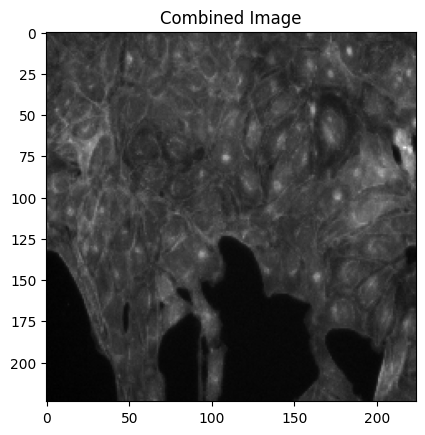

3647    2764.402062
4299    4634.466667
3534    2951.275862
240     2640.329897
3500    2690.694737
           ...     
2274    3214.580247
1881    2416.009091
2759    3472.259740
1814    2019.031746
1839    2984.736842
Name: MeanArea, Length: 922, dtype: float64

In [10]:
combined_image = (X_test_mp[0][:, :, 0] + X_test_mp[0][:, :, 1]) / 2.0  # + X_test_trip[0][:,:,2]

plt.imshow(combined_image, cmap='gray')
plt.title('Combined Image')
plt.show()
y_test_mp

In [11]:
### This are now 2 plates (without 24277) and two channels only normalized to 8 bit!

from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def initialize_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, kernel_size=(4,4), activation = 'relu', input_shape = (224,224,2)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
    #model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(128, kernel_size=(2,2), activation = 'relu'))
    #model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(20, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    initial_learning_rate = 0.01
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics='mae')

    return model

model = initialize_model()
es = EarlyStopping(patience = 10, restore_best_weights = True)

history = model.fit(X_train_mp,
                    y_train_mp,
                    validation_split = 0.3,
                    batch_size = 32,
                    epochs = 500,
                    callbacks = [es],
                    verbose = 1)


Epoch 1/500
81/81 [==============================] - 42s 510ms/step - loss: 2544297.5000 - mae: 1202.1960 - val_loss: 635875.4375 - val_mae: 651.8328
Epoch 2/500
81/81 [==============================] - 44s 542ms/step - loss: 589355.8750 - mae: 631.7391 - val_loss: 604076.1250 - val_mae: 637.0772
Epoch 3/500
81/81 [==============================] - 45s 560ms/step - loss: 590165.6250 - mae: 633.5802 - val_loss: 622658.8750 - val_mae: 643.2259
Epoch 4/500
81/81 [==============================] - 47s 575ms/step - loss: 594890.0625 - mae: 632.4868 - val_loss: 615079.8125 - val_mae: 640.2505
Epoch 5/500
81/81 [==============================] - 47s 582ms/step - loss: 597011.4375 - mae: 635.9392 - val_loss: 663585.1875 - val_mae: 659.3398
Epoch 6/500
81/81 [==============================] - 41s 504ms/step - loss: 627353.7500 - mae: 649.2443 - val_loss: 613815.6875 - val_mae: 639.7865
Epoch 7/500
81/81 [==============================] - 42s 520ms/step - loss: 604296.8750 - mae: 637.0474 - val_

In [1]:
model.save('model_2plates_2channels_8bit.keras')

NameError: name 'model' is not defined

In [34]:
from tensorflow.keras import regularizers

def initialize_model():

    model = models.Sequential()
    model.add(layers.Conv2D(8, kernel_size=(4,4), kernel_regularizer=regularizers.l2(0.001), activation = 'relu', input_shape = (224,224,3)))
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    model.add(layers.Conv2D(16, kernel_size=(3,3), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.Dropout(0.2))

    #model.add(layers.Conv2D(64, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    #model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())

    #model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss='mse',
                  optimizer='adam',
                  metrics='mae')

    return model

model = initialize_model()
es = EarlyStopping(patience = 10, restore_best_weights = True)

history = model.fit(X_train_trip,
                    y_train_trip,
                    validation_split = 0.3,
                    batch_size = 32,
                    epochs = 500,
                    callbacks = [es],
                    verbose = 1)


Epoch 1/500
81/81 [==============================] - 16s 196ms/step - loss: 1816548.7500 - mae: 1015.0461 - val_loss: 30599416.0000 - val_mae: 917.7473
Epoch 2/500
81/81 [==============================] - 11s 136ms/step - loss: 1217084.3750 - mae: 822.6281 - val_loss: 30445194.0000 - val_mae: 886.5058
Epoch 3/500
81/81 [==============================] - 11s 136ms/step - loss: 1066640.5000 - mae: 779.3048 - val_loss: 30434708.0000 - val_mae: 900.3067
Epoch 4/500
81/81 [==============================] - 11s 131ms/step - loss: 1116743.2500 - mae: 800.6110 - val_loss: 30099956.0000 - val_mae: 803.6149
Epoch 5/500
81/81 [==============================] - 11s 142ms/step - loss: 1087927.5000 - mae: 794.6486 - val_loss: 30813382.0000 - val_mae: 1119.3596
Epoch 6/500
81/81 [==============================] - 12s 145ms/step - loss: 1093027.2500 - mae: 739.9286 - val_loss: 30146498.0000 - val_mae: 797.7654
Epoch 7/500
81/81 [==============================] - 11s 135ms/step - loss: 911705.4375 - ma

KeyboardInterrupt: 

In [18]:
model.save('model_2plates_3channels.keras')

In [20]:
base_model_score = np.sum((concatenated_df['MeanArea'] - concatenated_df['MeanArea'].mean())**2)/concatenated_df.shape[0]
base_model_score

35534635.01781884

In [21]:
model.evaluate(X_test_trip, y_test_trip)
print(base_model_score)

29/29 [==============================] - 3s 83ms/step - loss: 140261520.0000 - mae: 704.3266
35534635.01781884


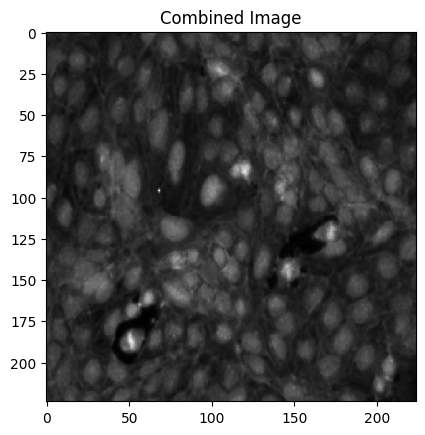

3683    2142.320611
4412    3526.108108
2584    1888.381944
69      3285.250000
1844    2406.880342
           ...     
1068    2027.042373
4351    2319.056075
3027    2880.350000
3455    1956.409449
1898    2748.107527
Name: MeanArea, Length: 921, dtype: float64

In [24]:
model.predict(X_test_trip[0].reshape(1, 224, 224, 3))

1/1 [==============================] - 0s 80ms/step


array([[2005.8987]], dtype=float32)

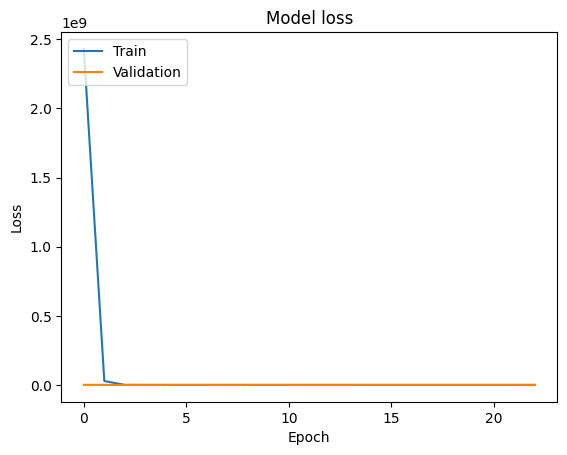

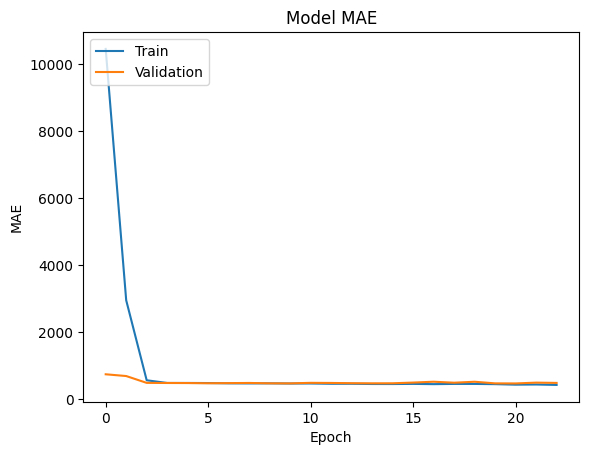

In [28]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation metrics (e.g., MAE)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot learning curves for the model trained with data from both channels
plot_learning_curves(history)